In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
Ns = [200,800]
K = 23

n_repeat = 1000

In [4]:
err = np.zeros((2,len(Ns),n_repeat,K))

np.random.seed(0)
for dist in range(2):
    for i,N in enumerate(Ns):
        for j in range(n_repeat):
            print(dist,i,j)
            clear_output(wait=True)
            v = np.ones(N)
            v /= np.linalg.norm(v)

            d = .2
            M = int(N/d)
            if dist ==0:
                X = np.random.randn(N,M)
            else:
                X = np.random.rand(N,M)*2-1
            A = X@X.T/M

            x_true = np.linalg.solve(A,v)

            Q,(αs,βs) = lanczos_reorth(A.astype(np.single),v,K,0)

            T = np.diag(αs) + np.diag(βs[:-1],1) + np.diag(βs[:-1],-1)
            e0 = np.zeros(K)
            e0[0] = 1

            for k in range(K):
                
                e = x_true - Q[:,:k].astype(np.double)@np.linalg.solve(T[:k,:k].astype(np.double),e0[:k].astype(np.double))
                err[dist,i,j,k] = np.sqrt(e.T@A@e)

1 1 375


In [5]:
np.savez_compressed('MP_err',err,allow_pickle=True)

In [6]:
npz = np.load('MP_err.npz',allow_pickle=True)
err = npz.f.arr_0

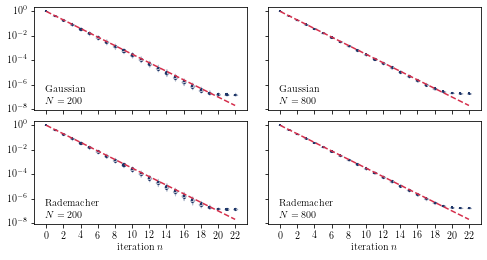

In [7]:
fig,axs = plt.subplots(2,len(Ns),figsize=(8,4),sharex=True,sharey=True)

fig.subplots_adjust(wspace=.1,hspace=.1)

σ = .05
for dist in range(2):
    for i,N in enumerate(Ns):

        if dist==0:
            dist_name='Gaussian'
        else:
            dist_name='Rademacher'
        axs[dist,i].text(.05,.05,f'{dist_name}\n$N = {N}$',ha='left', va='bottom', transform=axs[dist,i].transAxes)
        axs[dist,i].plot(d**(np.arange(K)/2)/np.sqrt(1-d**2),color=c3,ls='--')
        violin_parts = axs[dist,i].violinplot(err[dist,i]/err[dist,i,:,0,None],positions=np.arange(K),quantiles=[[1-σ,σ]]*K,showmeans=True,showextrema=False)

        for partname in ['cquantiles','cmeans']:
            vp = violin_parts[partname]
            vp.set_edgecolor(c1)
            vp.set_linewidth(1)
        vp.set_linewidth(2)

        for vp in violin_parts['bodies']:
            vp.set_facecolor(c1)
            vp.set_edgecolor(c1)


        axs[1,i].set_xlabel('iteration $n$')
    
axs[0,0].set_yscale('log')
axs[0,0].set_yticks([1e-8,1e-6,1e-4,1e-2,1])

axs[0,0].set_xticks(range(0,24,2));

plt.savefig('imgs/mp_system.pdf')